In [1]:
import block_methods as BM

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import integrate

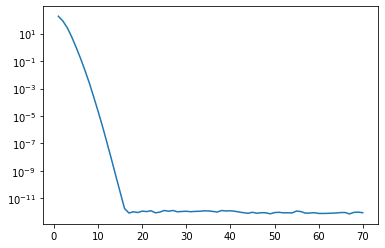

In [2]:
k = 100
b = 2
n = k*b
itr = 70

H = BM.randHerm(n, 1)
V = BM.randVec(n, b)
    
error = BM.mkplt(H, V, itr, b, BM.exp)

In [15]:
def const(t):
    return 1

In [20]:
def a_posteriori(f, z, n, b, k, h):
    
    """
    Input
    -----
    
    f  : function to integrate over
    n  : matrix size
    b  : block size
    k  : number of iteration
    h  : bound of h_(w,z)(H)
    
    Returns
    -------
    value of the contour integral
    
    """
    Eval, Evec = np.linalg.eigh(T)
    D = np.diag(1/(Eval-z))
    
    np.abs(f(z)) * h(z) * np.linalg.norm(-BM.Ei(n, b, k).T@Evec@D@Evec.T@BM.Ei(n, b, 1)@B_0)

In [16]:
def contour_eval(f, contour, endpts, n, b, k, h):
    
    """
    Input
    -----
    
    f  : function to integrate over
    contour  : a already defined contour
    endpts  : array of two endpoints for the integral
    
    Returns
    -------
    value of the contour integral
    
    """
        
    def F(t):
        z,dz = contour(t)
        return a_posteriori(f, z, n, b, k, h) * dz
    
    return 1/(2*np.pi) * sp.integrate.quad(f, endpts[0], endpts[1], epsabs=0) * '''bound error here'''
    

In [17]:
def disks(t, c = 0, r = 1):
    z = c + r*np.exp(t*1j)
    dz = 1j*r*np.exp(t*1j)
    return z, dz

In [19]:
print(contour_eval(const, u_disks, [0, np.pi]))

(3.141592653589793, 3.487868498008632e-14)
